In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

# Define the 3D U-Net model architecture
def build_3d_unet(input_shape=(128, 128, 64, 1), filters=16):
    inputs = tf.keras.layers.Input(input_shape)
    conv1 = layers.Conv3D(filters, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(filters, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = layers.Conv3D(filters*2, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(filters*2, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = layers.Conv3D(filters*4, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(filters*4, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = layers.Conv3D(filters*8, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv3D(filters*8, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv3DTranspose(filters*4, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = layers.Concatenate()([up5, conv3])
    conv5 = layers.Conv3D(filters*4, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv3D(filters*4, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv3DTranspose(filters*2, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = layers.Concatenate()([up6, conv2])
    conv6 = layers.Conv3D(filters*2, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv3D(filters*2, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv3DTranspose(filters, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([up7, conv1])
    conv7 = layers.Conv3D(filters, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv3D(filters, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv3D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Rebuild the model
model = build_3d_unet()


In [4]:
model1 = model.load_weights("model.h5")  # Load weights

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)]    0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 64, 16)     448       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 64, 16)     6928      ['conv3d[0][0]']              
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 64, 64, 32, 16)       0         ['conv3d_1[0][0]']            
 D)                                                                                           

In [6]:
import glob
import os
import nibabel as nib
from scipy import ndimage
import zipfile
from tqdm import tqdm
import numpy as np

In [7]:

# Data preprocessing functions
def normalize_volume(volume):
    min_val = volume.min()
    max_val = volume.max()
    if max_val > min_val:
        normalized = (volume - min_val) / (max_val - min_val)
    else:
        normalized = volume * 0.0
    return normalized

def prepare_data_3d(image_paths, mask_paths, target_shape=(128, 128, 64), normalize=True):
    images = []
    masks = []

    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        # Load image and mask
        img_nib = nib.load(img_path)
        mask_nib = nib.load(mask_path)

        # Get data
        img_data = img_nib.get_fdata()
        mask_data = mask_nib.get_fdata()

        # Resize to target shape
        img_resized = ndimage.zoom(img_data, (target_shape[0]/img_data.shape[0],
                                             target_shape[1]/img_data.shape[1],
                                             target_shape[2]/img_data.shape[2]), order=1)
        mask_resized = ndimage.zoom(mask_data, (target_shape[0]/mask_data.shape[0],
                                              target_shape[1]/mask_data.shape[1],
                                              target_shape[2]/mask_data.shape[2]), order=0)

        # Normalize if requested
        if normalize:
            img_resized = normalize_volume(img_resized)

        # Binarize mask
        mask_resized = (mask_resized > 0.5).astype(np.float32)

        # Add channel dimension
        img_resized = np.expand_dims(img_resized, axis=-1)
        mask_resized = np.expand_dims(mask_resized, axis=-1)

        # Append to lists
        images.append(img_resized)
        masks.append(mask_resized)

    # Convert to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks

In [11]:
# Load and preprocess images and masks
image_paths = glob.glob(os.path.join("data/test_images", "*.nii.gz"))
mask_paths = glob.glob(os.path.join("data/test_masks", "*.nii.gz"))

# Prepare images and masks
images, masks = prepare_data_3d(image_paths, mask_paths, target_shape=(128, 128, 64))

# Ensure both images and masks are NumPy arrays
print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")

# Evaluate the model

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=BinaryCrossentropy(), 
              metrics=[BinaryAccuracy(), tf.keras.metrics.MeanIoU(num_classes=2)])

test_loss, test_acc, test_iou = model.evaluate(images, masks)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test IoU: {test_iou}")


100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


Images shape: (31, 128, 128, 64, 1), Masks shape: (31, 128, 128, 64, 1)

1/1 [==============================] - 81s 81s/step - loss: 0.0258 - binary_accuracy: 0.9910 - mean_io_u_1: 0.4649
Test Loss: 0.02583129331469536, Test Accuracy: 0.9910348057746887, Test IoU: 0.4648759365081787


In [9]:
import io
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras

In [10]:
def create_overlay(original_image, mask, color=(255, 255, 0, 128)):  # Yellow with 50% transparency
    if original_image.mode != 'RGBA':
        original_image = original_image.convert('RGBA')
    
    overlay = Image.new('RGBA', original_image.size, (0, 0, 0, 0))
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[y, x] > 0:
                overlay.putpixel((x, y), color)
    
    return Image.alpha_composite(original_image, overlay)

def preprocess_image(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 64, axis=3)  # Repeat 64 times for depth
    image = np.expand_dims(image, axis=-1)  # Add final singleton dimension
    
    return image

def postprocess_mask(mask):
    mask = np.max(mask, axis=3)
    mask = (mask > 0.5).astype(np.uint8) * 255  # Threshold and scale
    mask = np.squeeze(mask)  # Remove extra dimensions
    return mask

def segment_image(image_path):
    try:
        original_image = Image.open(image_path).convert('RGB')
        original_size = original_image.size
        
        processed_image = preprocess_image(original_image)
        print(f"Preprocessed image shape: {processed_image.shape}")
        
        prediction = model.predict(processed_image, verbose=0)
        print(f"Model prediction shape: {prediction.shape}")
        
        mask = postprocess_mask(prediction)
        print(f"Final mask shape: {mask.shape}")
        
        mask_image = Image.fromarray(mask).resize(original_size, Image.Resampling.NEAREST)
        mask = np.array(mask_image)
        
        result_image = create_overlay(original_image, mask)
        
        output_path = "segmented_image.png"
        result_image.save(output_path)
        print(f"Segmented image saved to {output_path}")
    except Exception as e:
        print(f"Error processing image: {str(e)}")

# Example usage
image_path = "testing images\\42.nii_slice_035.jpg"  # Replace with your image file path
segment_image(image_path)


Error processing image: [Errno 2] No such file or directory: 'testing images\\42.nii_slice_035.jpg'


In [13]:
model.save("unet_3d_model.h5")

e:\Sem-4\ChatBot\emv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
!pip install matplotlib

  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.56.0-cp39-cp39-win_amd64.whl (2.2 MB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl (55 kB)
     ------------------------------------ 111.1/111.1 KB 807.0 kB/s eta 0:00:00


You should consider upgrading via the 'E:\Sem-4\ChatBot\emv\Scripts\python.exe -m pip install --upgrade pip' command.


T1 Model Predictions:
1/1 [==============================] - 2s 2s/step


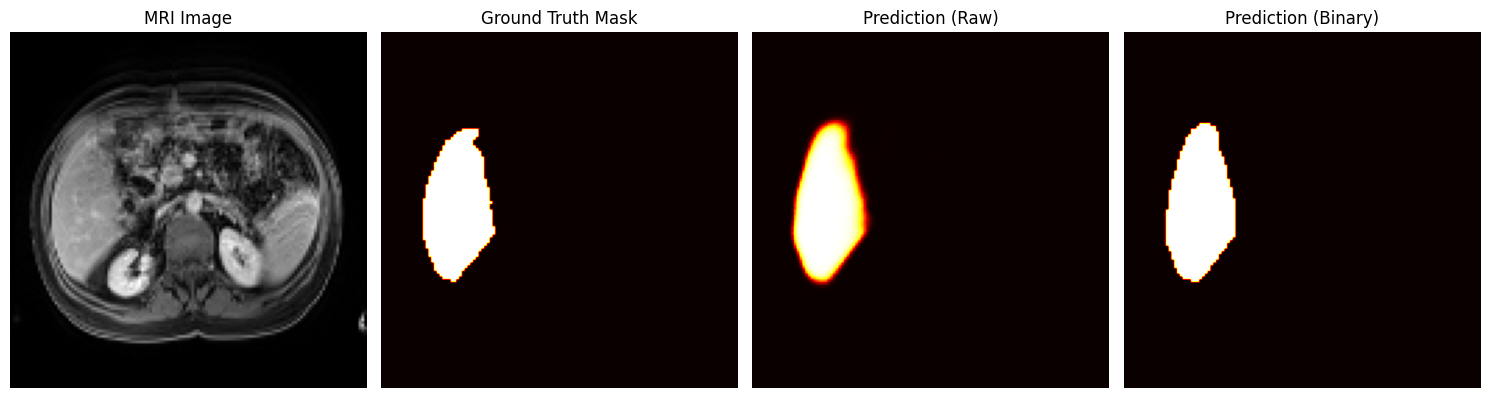

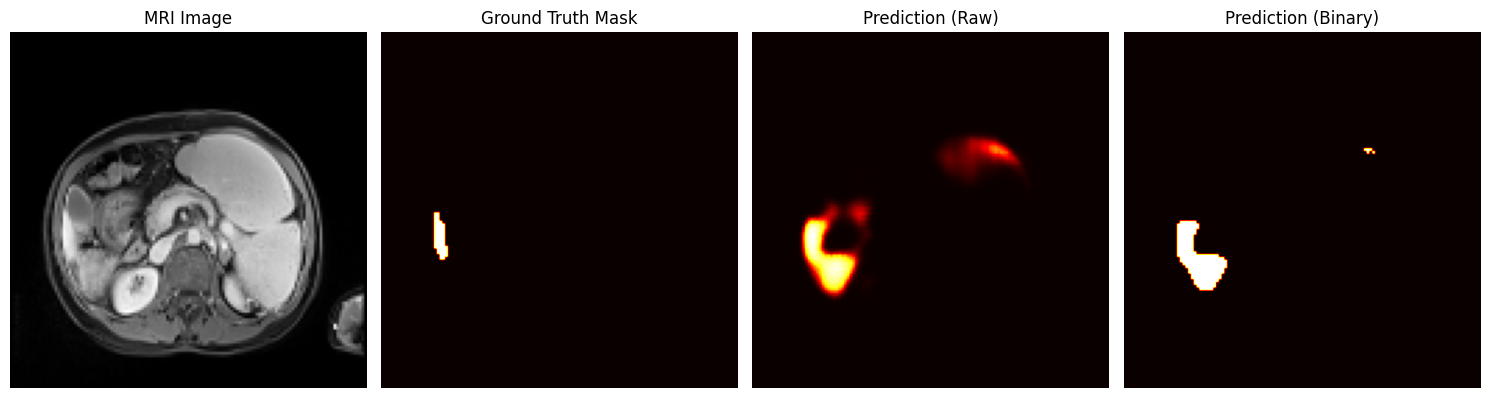

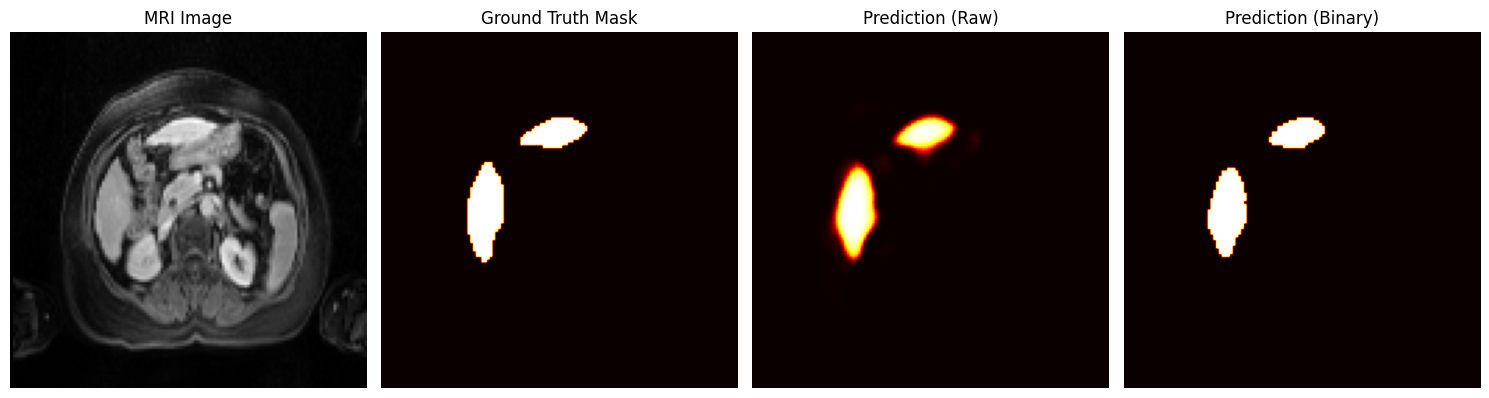

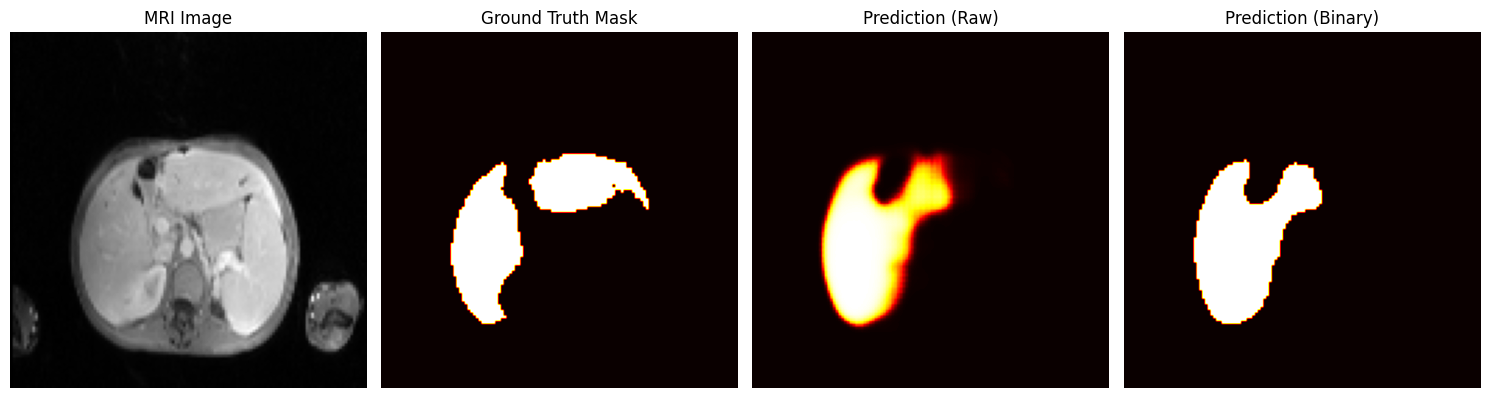

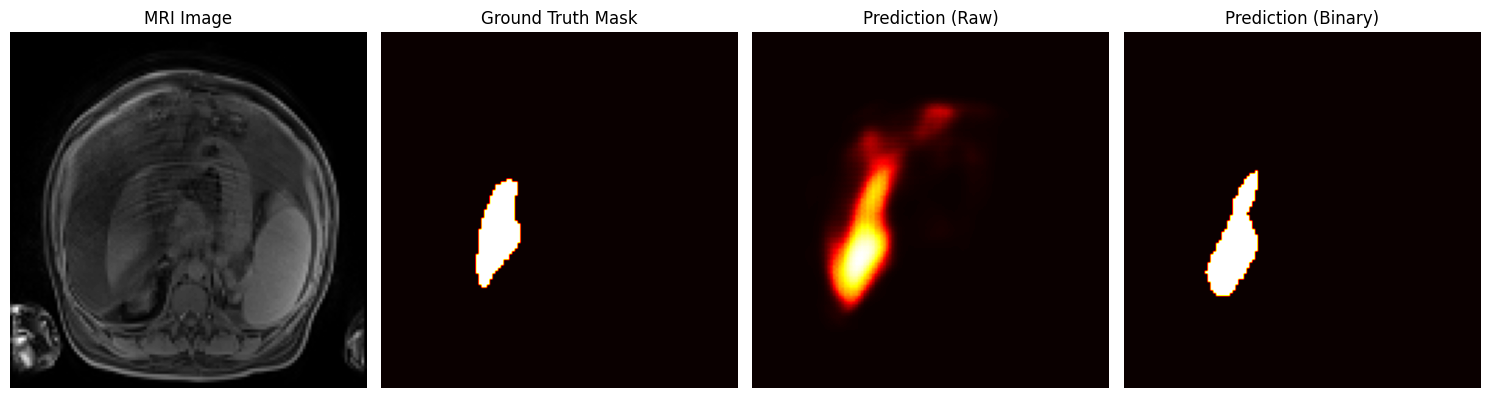

In [13]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, images, masks, num_samples=5):
    # Make predictions
    predictions = model.predict(images[:num_samples])

    # Visualize predictions
    for i in range(num_samples):
        # Select a slice in the middle of the volume
        slice_num = images[i].shape[2] // 2

        # Get the image, mask, and prediction for this slice
        img_slice = images[i][:, :, slice_num, 0]
        mask_slice = masks[i][:, :, slice_num, 0]
        pred_slice = predictions[i][:, :, slice_num, 0]

        # Threshold the prediction
        pred_slice_binary = (pred_slice > 0.5).astype(np.float32)

        # Visualize
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(img_slice.T, cmap='gray')
        plt.title('MRI Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(mask_slice.T, cmap='hot')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(pred_slice.T, cmap='hot')
        plt.title('Prediction (Raw)')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(pred_slice_binary.T, cmap='hot')
        plt.title('Prediction (Binary)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize predictions for T1 model
print("T1 Model Predictions:")
visualize_predictions(model, images, masks)